In [1]:
import os
import fnmatch
import numpy as np
import pandas as pd
import json
import warnings
warnings.simplefilter("ignore")

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import scale
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [3]:
from tqdm import tqdm
from joblib import Parallel, delayed
import time

In [4]:
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

## Data Prepare

In [7]:
#coco-search
# Load the JSON data
fv_fixations_path = "/home/oct/COCO_Search18-and-FV/dataset/coco_search18_FV_fixations_512x320.json"
tp_fixations_path = "/home/oct/COCO_Search18-and-FV/dataset/coco_search18_TP_fixations_512x320.json"

with open(fv_fixations_path, 'r') as fv_file:
    fv_fixations_data = json.load(fv_file)

with open(tp_fixations_path, 'r') as tp_file:
    tp_fixations_data = json.load(tp_file)

print("FV Fixations Data Loaded:", len(fv_fixations_data))
print("TP Fixations Data Loaded:", len(tp_fixations_data))



FV Fixations Data Loaded: 43048
TP Fixations Data Loaded: 49001


In [8]:
# Load the .npy file
saccade_data_path = "/home/oct/COCO_Search18-and-FV/dataset/cocosearch18_saccade_raw_trainval_tp.npy"
saccade_data = np.load(saccade_data_path, allow_pickle=True)

# Print the first few entries
print("First few entries in the saccade data:", saccade_data[:1])

First few entries in the saccade data: [{'trial_ind': 1, 'name': '000000478726.jpg', 'subject': 2, 'task': 'bottle', 'condition': 'present', 'bbox': [1063, 68, 95, 334], 'amplitude': array([ 1.75,  3.97, 13.04,  2.11]), 'direction': array(['LEFT', 'UP', 'RIGHT', 'UP'], dtype='<U5'), 'T': array([22, 44, 51, 22]), 'X_start': array([ 847. ,  803. ,  735.2, 1114.5]), 'Y_start': array([516.3, 479.9, 385.2, 275.6]), 'X_end': array([ 804.8,  731.5, 1115.6, 1125.5]), 'Y_end': array([482.7, 380.9, 268.1, 212.1]), 'length': 4, 'correct': 1, 'RT': 1159, 'split': 'train'}]


In [9]:
from scipy.stats import kurtosis, skew

def calculate_statistics(data, key_x='X', key_y='Y', key_t='T',name='name',subject='subject',length='length'):
    stats = []
    for item in data:
        if key_x in item and key_y in item and key_t in item and item[key_x] and item[key_y] and item[key_t]:  # Ensure the keys exist and are not empty
            x_values = item[key_x]
            y_values = item[key_y]
            durations = item[key_t]
            # Calculate saccade distances
            distances = np.sqrt(np.diff(x_values)**2 + np.diff(y_values)**2)
            
            if len(distances) > 0 and len(durations) > 0:  # Ensure there are distances and durations to calculate statistics
                mean_dist = np.mean(distances)
                var_dist = np.var(distances)
                kurt_dist = kurtosis(distances)
                skew_dist = skew(distances)
                
                mean_dur = np.mean(durations)
                var_dur = np.var(durations)
                kurt_dur = kurtosis(durations)
                skew_dur = skew(durations)
                stats.append({
                    'name': item[name],
                    'subject': item[subject],
                    'length': item[length],
                    'mean_distance': mean_dist,
                    'variance_distance': var_dist,
                    'kurtosis_distance': kurt_dist,
                    'skewness_distance': skew_dist,
                    'mean_duration': mean_dur,
                    'variance_duration': var_dur,
                    'kurtosis_duration': kurt_dur,
                    'skewness_duration': skew_dur
                })
    return stats

# Calculate statistics for FV and TP fixations
fv_statistics = calculate_statistics(fv_fixations_data)
tp_statistics = calculate_statistics(tp_fixations_data)

print("FV Fixations Statistics (first 5):", fv_statistics[:5])
print("TP Fixations Statistics (first 5):", tp_statistics[:5])

FV Fixations Statistics (first 5): [{'name': '000000128398.jpg', 'subject': 101, 'length': 15, 'mean_distance': 60.7116044316413, 'variance_distance': 1039.1725159073408, 'kurtosis_distance': -1.007891331678368, 'skewness_distance': 0.15415501465614576, 'mean_duration': 282.53333333333336, 'variance_duration': 18101.84888888889, 'kurtosis_duration': 0.5098116496710263, 'skewness_duration': 1.1681707519368763}, {'name': '000000128398.jpg', 'subject': 102, 'length': 18, 'mean_distance': 46.84740492337376, 'variance_distance': 1106.085357827809, 'kurtosis_distance': -1.1943425228366489, 'skewness_distance': 0.6083636466166538, 'mean_duration': 194.22222222222223, 'variance_duration': 10231.283950617282, 'kurtosis_duration': -0.3128318572867803, 'skewness_duration': 0.12885496029947857}, {'name': '000000128398.jpg', 'subject': 103, 'length': 15, 'mean_distance': 71.29654722056117, 'variance_distance': 873.088068712006, 'kurtosis_distance': -0.7563429073804677, 'skewness_distance': 0.307968

In [10]:
# Save fv_statistics and tp_statistics to JSON files
fv_statistics_path = "/home/oct/COCO_Search18-and-FV/dataset/fv_statistics_512x320.json"
tp_statistics_path = "/home/oct/COCO_Search18-and-FV/dataset/tp_statistics_512x320.json"

with open(fv_statistics_path, 'w') as fv_file:
    json.dump(fv_statistics, fv_file, indent=4)

with open(tp_statistics_path, 'w') as tp_file:
    json.dump(tp_statistics, tp_file, indent=4)

print(f"FV statistics saved to {fv_statistics_path}")
print(f"TP statistics saved to {tp_statistics_path}")

FV statistics saved to /home/oct/COCO_Search18-and-FV/dataset/fv_statistics_512x320.json
TP statistics saved to /home/oct/COCO_Search18-and-FV/dataset/tp_statistics_512x320.json


In [15]:
import json
import pandas as pd
from sklearn.model_selection import train_test_split  # 添加此行
from sklearn.preprocessing import StandardScaler


# Load FV and TP statistics from JSON files
fv_statistics_path = "/home/oct/COCO_Search18-and-FV/dataset/fv_statistics_512x320.json"
tp_statistics_path = "/home/oct/COCO_Search18-and-FV/dataset/tp_statistics_512x320.json"

with open(fv_statistics_path, 'r') as fv_file:
    fv_statistics = json.load(fv_file)

with open(tp_statistics_path, 'r') as tp_file:
    tp_statistics = json.load(tp_file)

#  Combine FV and TP statistics into a single DataFrame
fv_df = pd.DataFrame(fv_statistics)
tp_df = pd.DataFrame(tp_statistics)

# Add a 'class' column to distinguish FV and TP
fv_df['class'] = 'FV'
tp_df['class'] = 'TP'

# Concatenate the two DataFrames
combined_df = pd.concat([fv_df, tp_df], ignore_index=True)

# Drop rows with NaN values in features or target
combined_df = combined_df.dropna()

# Separate features (X) and target labels (y)
X = combined_df.drop(columns=['class','name','subject','length'])  # All columns except 'class'
y = combined_df['class']  # The target column

# Split the data into training and testing sets (80:20 ratio)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train) 
y_test_encoded = label_encoder.fit_transform(y_test)  

print(y_train_encoded[:3])
print(y_test_encoded[:3])
print(y_train[:3])
print(y_test[:3])

print("len of X_train_scaled:")
print(len(X_train_scaled))
print("len of y_train_encoded:")
print(len(y_train_encoded)) 


print("len of X_test_scaled:")
print(len(X_test_scaled))
print("len of y_test_encoded:")
print(len(y_test_encoded))

[0 0 1]
[1 0 1]
36418    FV
12444    FV
79750    TP
Name: class, dtype: object
53532    TP
42353    FV
53022    TP
Name: class, dtype: object
len of X_train_scaled:
66022
len of y_train_encoded:
66022
len of X_test_scaled:
16506
len of y_test_encoded:
16506


In [4]:
root_folder = "../FEATURE"
eye = "Dominant"
subjs = range(1,31) 
watch_types = ["TASK","FV"]
all_features = []
i = 0
for root, dirs, files in os.walk(root_folder):
    for file in files:
        if fnmatch.fnmatch(file, "*.csv"):
            i = i+1
            file_path = os.path.join(root,file)
            base_name = os.path.basename(file_path)
            parts = base_name.split("_")
            subj_index = parts.index("subj")
            dataset   = parts[0]
            if subj_index == 2:
                videoname = parts[1]
            else:
                videoname = '_'.join(parts[1:subj_index] )
            subj = parts[subj_index + 1]
            watch_type = parts[subj_index + 2]
            features = pd.read_csv(file_path)
            df = pd.DataFrame(features)
            df["class"] = watch_type
            all_features.append(df)

print(f"all csv has {i}")
print(all_features[:10])

all csv has 2580
[   fix_cut  fix_fre  fix_dur_mean  fix_dur_std  fix_dur_skew  fix_dur_kurt  \
0       94     1.61    610.404255   586.216435      3.245284     13.044965   

   fix_first_time  fix_first_dur  sac_cut  sac_fre  ...  sac_amp_std  \
0             1.0          303.0       93     1.59  ...     1.533095   

   sac_amp_skew  sac_amp_kurt  sac_amp_peak  sac_vel_mean  sac_vel_std  \
0      1.966431      4.404176          8.41    513.782151   396.875732   

   sac_vel_skew  sac_vel_kurt  sac_vel_peak  class  
0      0.592807     -1.231546        1390.0   TASK  

[1 rows x 26 columns],    fix_cut  fix_fre  fix_dur_mean  fix_dur_std  fix_dur_skew  fix_dur_kurt  \
0      141     2.41     384.58156   227.126864      2.203663      5.886186   

   fix_first_time  fix_first_dur  sac_cut  sac_fre  ...  sac_amp_std  \
0             1.0          424.0      140     2.39  ...     1.977008   

   sac_amp_skew  sac_amp_kurt  sac_amp_peak  sac_vel_mean  sac_vel_std  \
0       0.57304     -0.68

In [ ]:
all_data = pd.concat(all_features, ignore_index=True)

# Separate features (X) and target labels (y)
X = all_data.drop(columns=['class'])  # All columns except 'class'
y = all_data['class']  # The target column

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled).fillna(0)
X_test_scaled = pd.DataFrame(X_test_scaled).fillna(0)

print(X_train[:3])
print(X_train_scaled[:3])

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)  # This will transform "TASK" a
y_test_encoded = label_encoder.fit_transform(y_test)  
print(y_train_encoded[:3])
print(y_test_encoded[:3])

Training data shape: (2064, 25)
Testing data shape: (516, 25)
      fix_cut  fix_fre  fix_dur_mean  fix_dur_std  fix_dur_skew  fix_dur_kurt  \
1710       45     2.44    396.066667   240.043459      1.667919      2.478133   
2050      138     2.48    384.876812   267.864595      2.167974      6.621045   
2364       16     2.06    475.437500   317.286142      1.348230      1.089080   

      fix_first_time  fix_first_dur  sac_cut  sac_fre  ...  sac_amp_mean  \
1710            81.0          385.0     44.0     2.39  ...      3.719773   
2050             1.0          355.0    137.0     2.46  ...      2.589781   
2364             1.0          154.0     15.0     1.93  ...      3.098667   

      sac_amp_std  sac_amp_skew  sac_amp_kurt  sac_amp_peak  sac_vel_mean  \
1710     2.605366      0.605726     -0.821223          9.37    477.899318   
2050     3.796484      5.777879     39.103929         30.94    558.231241   
2364     2.102173      0.577597     -1.299560          6.77    533.056000   


In [75]:
# Initialize an empty dictionary to store training results
training_results = {}

# Example structure for storing results:
# training_results = {
#     "Algorithm_Name": {
#         "Accuracy": 0.95,
#         "Precision": 0.94,
#         "Recall": 0.93,
#         "F1_Score": 0.94
#     }
# }

print("Initialized empty dictionary for training results.")

Initialized empty dictionary for training results.


# PAC

          Feature  PCA Contribution (%)
kurtosis_distance             30.372362
skewness_duration             29.702088
skewness_distance             29.689256
kurtosis_duration             27.749637
variance_distance             26.391406
    mean_duration             26.372200
variance_duration             26.156788
    mean_distance             24.054453


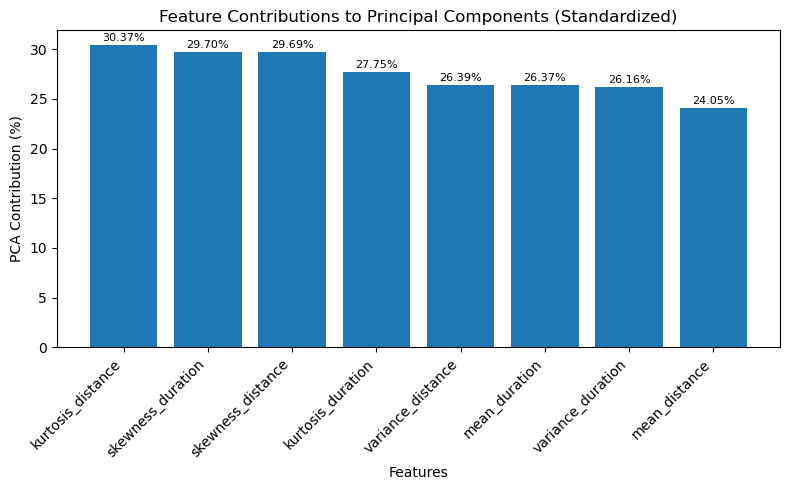

In [27]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 获取特征名称
feature_names = X.columns.tolist()

# 1. 标准化特征
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. 拟合 PCA 模型
pca = PCA(n_components=len(feature_names))
X_pca = pca.fit_transform(X_scaled)

# 3. 计算每个特征的贡献（加权绝对载荷 × 解释方差）
components = np.abs(pca.components_)
explained_var_ratio = pca.explained_variance_ratio_

# 4. 计算每个特征的总体贡献
feature_scores = np.dot(explained_var_ratio, components)

# 5. 构建结果表格
feature_contributions = pd.DataFrame({
    "Feature": feature_names,
    "PCA Contribution (%)": feature_scores * 100
})

# 6. 排序
feature_contributions = feature_contributions.sort_values(by="PCA Contribution (%)", ascending=False)

# 7. 打印结果
print(feature_contributions.to_string(index=False))

# 8. 绘图 + 在图中标注数值
plt.figure(figsize=(8, 5))
bars = plt.bar(feature_contributions["Feature"], feature_contributions["PCA Contribution (%)"])
plt.ylabel("PCA Contribution (%)")
plt.xlabel("Features")
plt.title("Feature Contributions to Principal Components (Standardized)")
plt.xticks(rotation=45, ha='right')

# 9. 在柱子上标注具体数值
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.2, f'{height:.2f}%', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


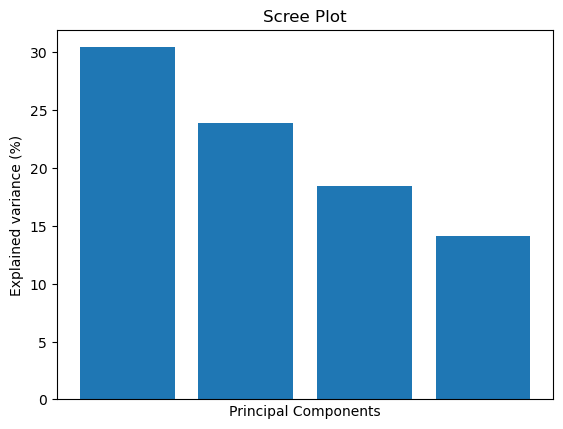

In [17]:
pca = PCA(n_components=4)  # Project data to 2 components for visualization
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.fit_transform(X_test_scaled)

per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
labels = [str(x) for x in range(1, len(per_var)+1)]

#plot scree plot
plt.bar(x=range(1, len(per_var)+1), height=per_var)
plt.tick_params(axis='x', which = 'both', bottom=False, top=False, labelbottom=False)
plt.ylabel("Explained variance (%)")
plt.xlabel('Principal Components')
plt.title('Scree Plot')
plt.show()

In [60]:
from sklearn.svm import SVC
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import time

# Reduced parameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.1],
    'kernel': ['rbf']
}

# Initialize SVM
svm = SVC()

# Measure start time
start_time = time.time()

# Initialize variables to track the best model
best_score = 0
best_params = None
best_model = None

# Create a parameter grid and use tqdm to show progress
param_combinations = list(ParameterGrid(param_grid))
with tqdm(total=len(param_combinations), desc="Grid Search Progress") as pbar:
    for params in param_combinations:
        # Set parameters for the SVM
        svm.set_params(**params)
        
        # Train the model
        svm.fit(X_train_pca, y_train_encoded)
        
        # Evaluate the model
        y_pred = svm.predict(X_test_pca)
        score = accuracy_score(y_test_encoded, y_pred)
        
        # Update the best model if the current one is better
        if score > best_score:
            best_score = score
            best_params = params
            best_model = svm
        
        # Update the progress bar
        pbar.update(1)

# Measure end time
end_time = time.time()

# Print the best hyperparameters and time taken
print("Best hyperparameters for SVM:", best_params)
print(f"Best accuracy: {best_score:.4f}")
print(f"Grid search completed in {end_time - start_time:.2f} seconds.")

Grid Search Progress: 100%|██████████| 6/6 [04:42<00:00, 47.04s/it]

Best hyperparameters for SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best accuracy: 0.8591
Grid search completed in 282.25 seconds.


Accuracy: 0.8569611050527081
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.91      0.87      8578
           1       0.89      0.80      0.84      7928

    accuracy                           0.86     16506
   macro avg       0.86      0.85      0.86     16506
weighted avg       0.86      0.86      0.86     16506



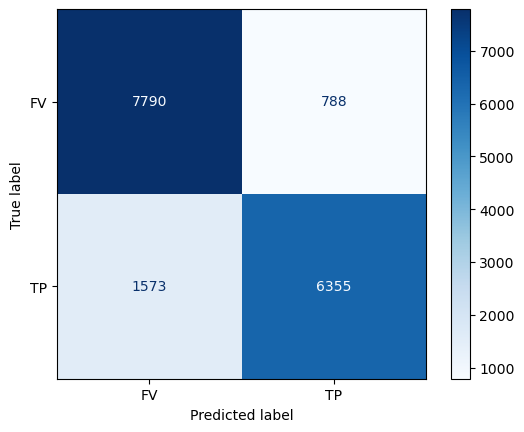

Training results updated: {'SVM': {'Accuracy': 0.8569611050527081, 'Precision': 0.8597044634338877, 'Recall': 0.8569611050527081, 'F1_Score': 0.8563651863880642}}


In [76]:
# Predict the class labels for the test set
y_pred = best_model.predict(X_test_pca)  # Assuming you've already scaled and transformed X_test_pca

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test_encoded, y_pred)  # Replace y_test_encoded with your test labels
print("Accuracy:", accuracy)

# Print the classification report
print("Classification Report:\n", classification_report(y_test_encoded, y_pred))

# Define the class names (make sure they match your label encoding)
class_names = ['FV', 'TP']

# Display the confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(
    best_model,
    X_test_pca,  # Your test data
    y_test_encoded,  # Your true labels (encoded)
    display_labels=class_names,  # Class labels
    cmap=plt.cm.Blues  # Color map
)

# Show the confusion matrix
plt.show()

# Store the training results for the best SVM model
training_results["SVM"] = {
    "Accuracy": accuracy_score(y_test_encoded, y_pred),
    "Precision": classification_report(y_test_encoded, y_pred, output_dict=True)["weighted avg"]["precision"],
    "Recall": classification_report(y_test_encoded, y_pred, output_dict=True)["weighted avg"]["recall"],
    "F1_Score": classification_report(y_test_encoded, y_pred, output_dict=True)["weighted avg"]["f1-score"]
}

print("Training results updated:", training_results)

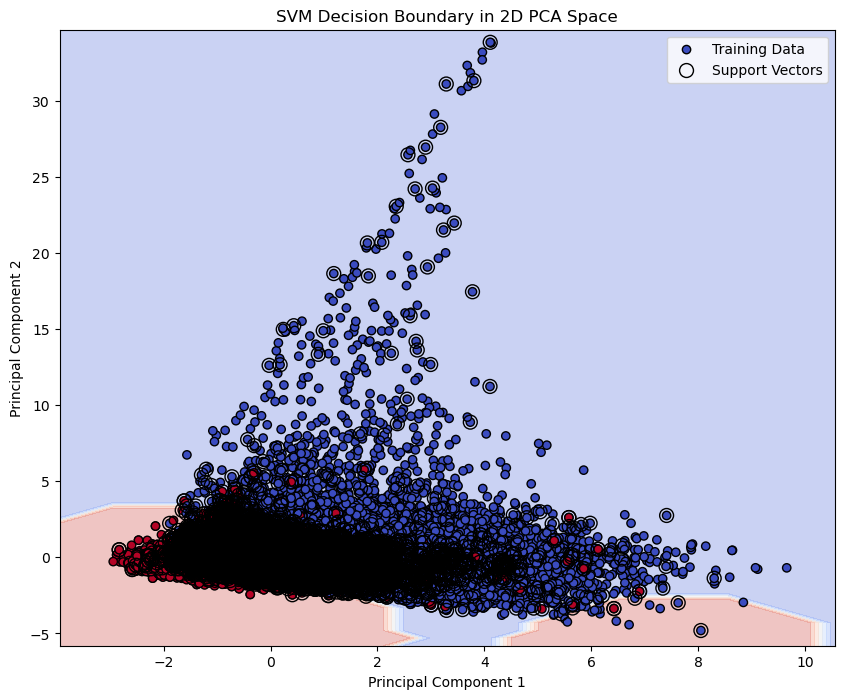

In [74]:
import matplotlib.pyplot as plt
import numpy as np

# Select the first two principal components for visualization
X_train_pca_2d = X_train_pca[:, :2]

# Define the grid range for the first two components
x_min, x_max = X_train_pca_2d[:, 0].min() - 1, X_train_pca_2d[:, 0].max() + 1
y_min, y_max = X_train_pca_2d[:, 1].min() - 1, X_train_pca_2d[:, 1].max() + 1

# Create a 2D grid for the first two components
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.5),
                     np.arange(y_min, y_max, 0.5))

# Create a grid with 2 features
grid = np.c_[xx.ravel(), yy.ravel(), np.zeros((xx.ravel().shape[0], 2))]

# Predict over the grid
Z = best_model.predict(grid)
Z = Z.reshape(xx.shape)

# Create a 2D plot
plt.figure(figsize=(10, 8))

# Plot the decision boundary as a contour plot
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)

# Scatter plot of the training data (first two components)
plt.scatter(X_train_pca_2d[:, 0], X_train_pca_2d[:, 1],
            c=y_train_encoded, cmap=plt.cm.coolwarm, edgecolors='k', label='Training Data')

# Scatter plot of support vectors (first two components)
plt.scatter(best_model.support_vectors_[:, 0], best_model.support_vectors_[:, 1],
            s=100, facecolors='none', edgecolors='k', marker='o', label='Support Vectors')

# Set labels and title
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('SVM Decision Boundary in 2D PCA Space')
plt.legend()

# Show the plot
plt.show()

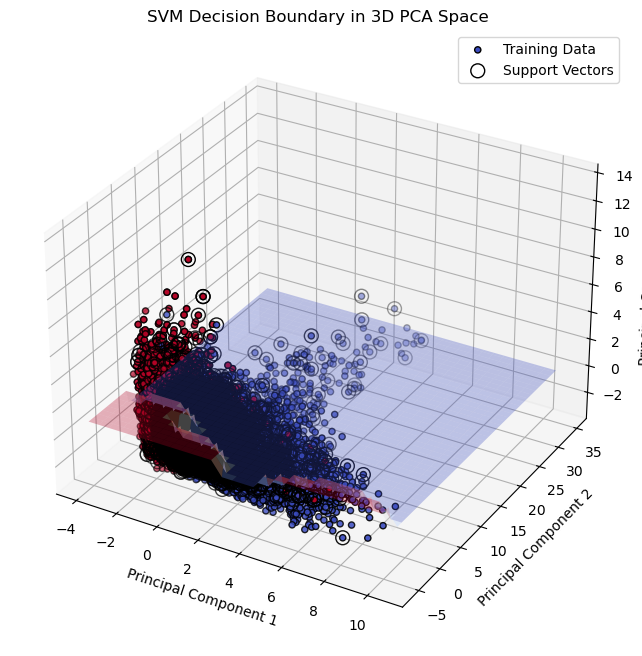

In [62]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

# Select the first three principal components for visualization
X_train_pca_3d = X_train_pca[:, :3]

# Define the grid range for the first two components
x_min, x_max = X_train_pca_3d[:, 0].min() - 1, X_train_pca_3d[:, 0].max() + 1
y_min, y_max = X_train_pca_3d[:, 1].min() - 1, X_train_pca_3d[:, 1].max() + 1

# Create a 2D grid for the first two components
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.5),
                     np.arange(y_min, y_max, 0.5))

# Create a grid with 4 features (fill the third and fourth dimensions with 0)
grid = np.c_[xx.ravel(), yy.ravel(), np.zeros((xx.ravel().shape[0], 2))]

# Predict over the grid
Z = best_model.predict(grid)
Z = Z.reshape(xx.shape)

# Create a 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the decision boundary as a surface
ax.plot_surface(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)

# Scatter plot of the training data (first three components)
ax.scatter(X_train_pca_3d[:, 0], X_train_pca_3d[:, 1], X_train_pca_3d[:, 2],
           c=y_train_encoded, cmap=plt.cm.coolwarm, edgecolors='k', label='Training Data')

# Scatter plot of support vectors (first three components)
if best_model.support_vectors_.shape[1] >= 3:
    ax.scatter(best_model.support_vectors_[:, 0], best_model.support_vectors_[:, 1], best_model.support_vectors_[:, 2],
               s=100, facecolors='none', edgecolors='k', marker='o', label='Support Vectors')

# Set labels and title
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('SVM Decision Boundary in 3D PCA Space')
ax.legend()

# Show the plot
plt.show()

## Support Vector Machine (SVM)

Accuracy: 0.6763565891472868
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.62      0.66       267
           1       0.64      0.74      0.69       249

    accuracy                           0.68       516
   macro avg       0.68      0.68      0.68       516
weighted avg       0.68      0.68      0.68       516



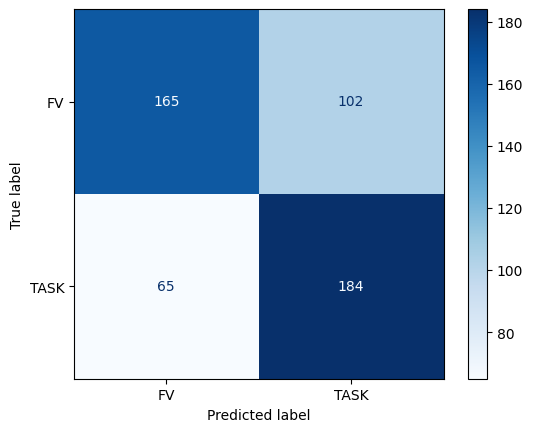

In [95]:
svm_model = SVC(kernel='linear')  # or 'rbf', 'poly', etc.

# Train the classifier
svm_model.fit(X_train, y_train_encoded)

# Predict on the test data
y_pred = svm_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test_encoded, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test_encoded, y_pred))

class_names = ['FV', 'TASK']
disp = ConfusionMatrixDisplay.from_estimator(
        svm_model,
        X_test,
        y_test_encoded,
        display_labels=class_names,
        cmap=plt.cm.Blues)

Accuracy: 0.6705426356589147
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.62      0.66       267
           1       0.64      0.72      0.68       249

    accuracy                           0.67       516
   macro avg       0.67      0.67      0.67       516
weighted avg       0.67      0.67      0.67       516



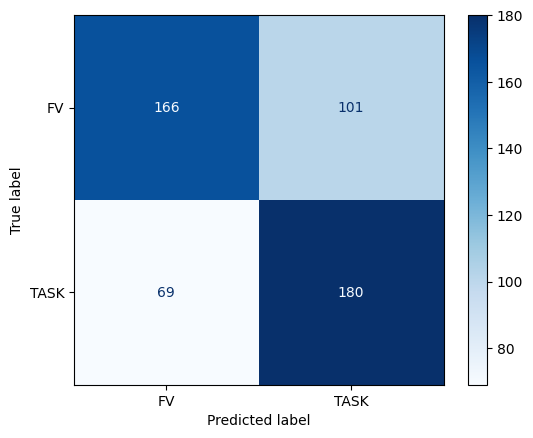

In [93]:
svm_model = SVC(kernel='linear')  # or 'rbf', 'poly', etc.

# Train the classifier
svm_model.fit(X_train_scaled, y_train_encoded)

# Predict on the test data
y_pred = svm_model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test_encoded, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test_encoded, y_pred))

class_names = ['FV', 'TASK']
disp = ConfusionMatrixDisplay.from_estimator(
        svm_model,
        X_test_scaled,
        y_test_encoded,
        display_labels=class_names,
        cmap=plt.cm.Blues)

Accuracy: 0.6937984496124031
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.58      0.66       267
           1       0.64      0.82      0.72       249

    accuracy                           0.69       516
   macro avg       0.71      0.70      0.69       516
weighted avg       0.71      0.69      0.69       516



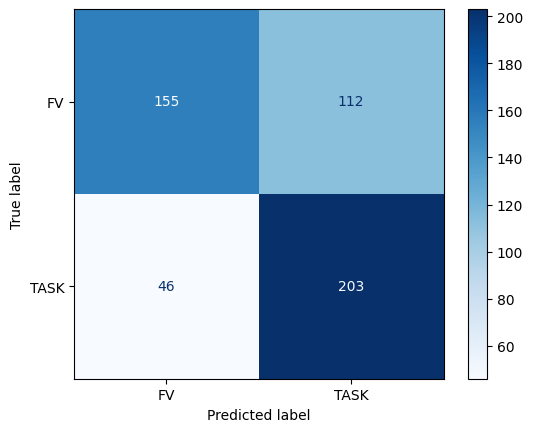

In [99]:
svm_model_poly = SVC(kernel='poly')  # or 'rbf', 'poly', etc.

# Train the classifier
svm_model_poly.fit(X_train_scaled, y_train_encoded)

# Predict on the test data
y_pred = svm_model_poly.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test_encoded, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test_encoded, y_pred))

class_names = ['FV', 'TASK']
disp = ConfusionMatrixDisplay.from_estimator(
        svm_model_poly,
        X_test_scaled,
        y_test_encoded,
        display_labels=class_names,
        cmap=plt.cm.Blues)

Accuracy: 0.6647286821705426
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.50      0.61       267
           1       0.61      0.84      0.71       249

    accuracy                           0.66       516
   macro avg       0.69      0.67      0.66       516
weighted avg       0.69      0.66      0.66       516



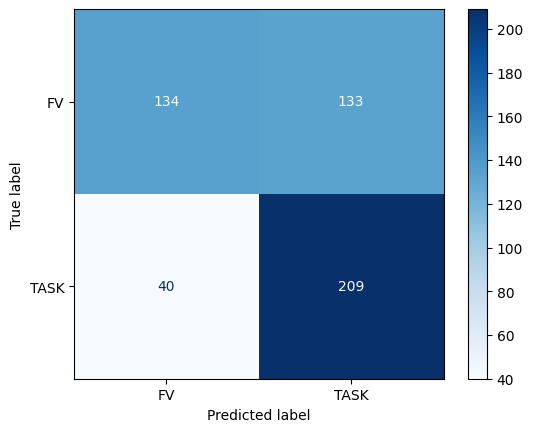

In [100]:
svm_model_poly = SVC(kernel='poly')  # or 'rbf', 'poly', etc.

# Train the classifier
svm_model_poly.fit(X_train, y_train_encoded)

# Predict on the test data
y_pred = svm_model_poly.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test_encoded, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test_encoded, y_pred))

class_names = ['FV', 'TASK']
disp = ConfusionMatrixDisplay.from_estimator(
        svm_model_poly,
        X_test,
        y_test_encoded,
        display_labels=class_names,
        cmap=plt.cm.Blues)

Accuracy: 0.686046511627907
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.56      0.65       267
           1       0.63      0.82      0.72       249

    accuracy                           0.69       516
   macro avg       0.70      0.69      0.68       516
weighted avg       0.71      0.69      0.68       516



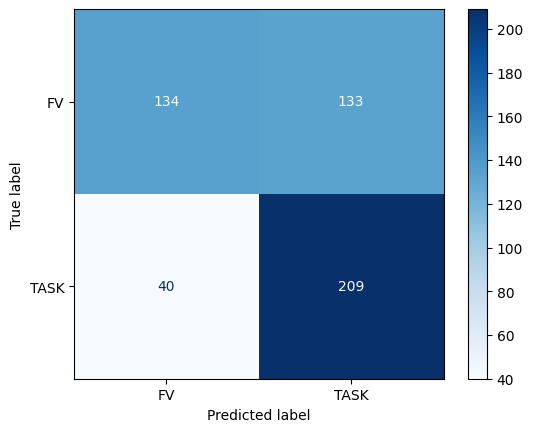

In [104]:
svm_model_rbf = SVC(kernel='rbf')  # or 'rbf', 'poly', etc.

# Train the classifier
svm_model_rbf.fit(X_train, y_train_encoded)

# Predict on the test data
y_pred = svm_model_rbf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test_encoded, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test_encoded, y_pred))

class_names = ['FV', 'TASK']
disp = ConfusionMatrixDisplay.from_estimator(
        svm_model_poly,
        X_test,
        y_test_encoded,
        display_labels=class_names,
        cmap=plt.cm.Blues)

Accuracy: 0.7054263565891473
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.65      0.69       267
           1       0.67      0.77      0.72       249

    accuracy                           0.71       516
   macro avg       0.71      0.71      0.71       516
weighted avg       0.71      0.71      0.70       516



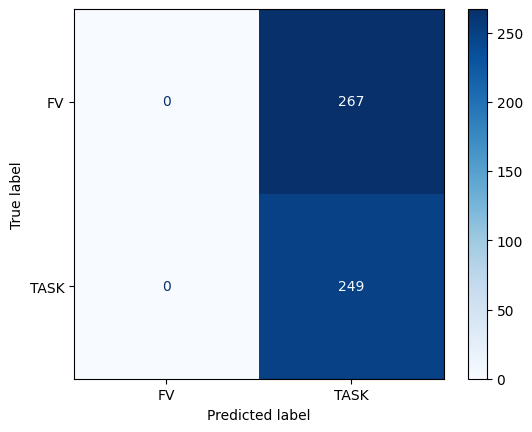

In [103]:
svm_model_rbf = SVC(kernel='rbf')  # or 'rbf', 'poly', etc.

# Train the classifier
svm_model_rbf.fit(X_train_scaled, y_train_encoded)

# Predict on the test data
y_pred = svm_model_rbf.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test_encoded, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test_encoded, y_pred))

class_names = ['FV', 'TASK']
disp = ConfusionMatrixDisplay.from_estimator(
        svm_model_poly,
        X_test_scaled,
        y_test_encoded,
        display_labels=class_names,
        cmap=plt.cm.Blues)

## Decision Tree

Accuracy: 0.9170604628619896
Classification Report:
               precision    recall  f1-score   support

          FV       0.88      0.97      0.92      8578
          TP       0.96      0.86      0.91      7928

    accuracy                           0.92     16506
   macro avg       0.92      0.92      0.92     16506
weighted avg       0.92      0.92      0.92     16506



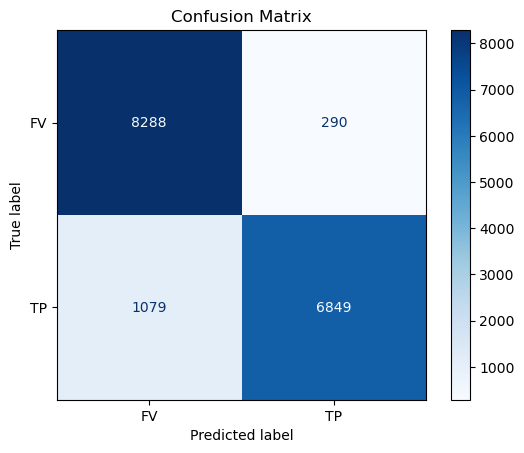

Training results updated: {'SVM': {'Accuracy': 0.8569611050527081, 'Precision': 0.8597044634338877, 'Recall': 0.8569611050527081, 'F1_Score': 0.8563651863880642}, 'DecisionTree': {'Accuracy': 0.9170604628619896, 'Precision': 0.9206249538857864, 'Recall': 0.9170604628619896, 'F1_Score': 0.9167121823665645}}


In [77]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Initialize the Decision Tree classifier
tree_model = DecisionTreeClassifier(random_state=42, max_depth=5)  # Adjust max_depth based on your needs

# Train the Decision Tree model
tree_model.fit(X_train_scaled, y_train_encoded)  # Use encoded labels for training

# Predict on the test data
y_pred_encoded = tree_model.predict(X_test_scaled)  # Predictions are encoded

# Convert predictions back to original labels
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Define class names
class_names = label_encoder.classes_  # ['FV', 'TP']

# Display the confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(
    y_test,  # True labels (original)
    y_pred,  # Predicted labels (original)
    display_labels=class_names,
    cmap=plt.cm.Blues
)

# Show the confusion matrix
plt.title("Confusion Matrix")
plt.show()

training_results["DecisionTree"] = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": classification_report(y_test, y_pred, output_dict=True)["weighted avg"]["precision"],
    "Recall": classification_report(y_test, y_pred, output_dict=True)["weighted avg"]["recall"],
    "F1_Score": classification_report(y_test, y_pred, output_dict=True)["weighted avg"]["f1-score"]
}

print("Training results updated:", training_results)

## Random Forest

Accuracy: 0.9153641100205986
Classification Report:
               precision    recall  f1-score   support

          FV       0.87      0.98      0.92      8578
          TP       0.98      0.84      0.91      7928

    accuracy                           0.92     16506
   macro avg       0.93      0.91      0.91     16506
weighted avg       0.92      0.92      0.91     16506



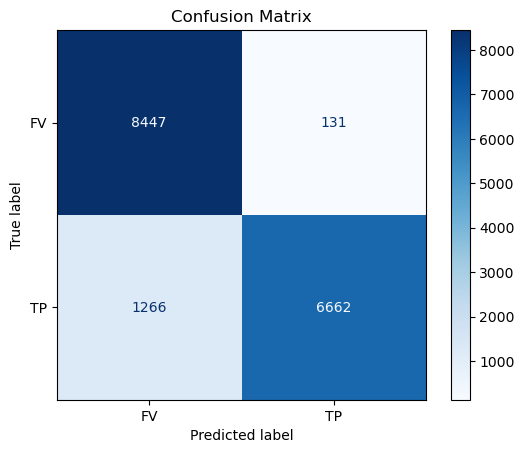

Training results updated: {'SVM': {'Accuracy': 0.8569611050527081, 'Precision': 0.8597044634338877, 'Recall': 0.8569611050527081, 'F1_Score': 0.8563651863880642}, 'DecisionTree': {'Accuracy': 0.9170604628619896, 'Precision': 0.9206249538857864, 'Recall': 0.9170604628619896, 'F1_Score': 0.9167121823665645}, 'RandomForest': {'Accuracy': 0.9153641100205986, 'Precision': 0.9230006550852881, 'Recall': 0.9153641100205986, 'F1_Score': 0.9147272941403064}}


In [78]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Initialize the Random Forest classifier
rf_model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=5)  # Adjust hyperparameters as needed

# Train the Random Forest model
rf_model.fit(X_train_scaled, y_train_encoded)  # Use encoded labels for training

# Predict on the test data
y_pred_encoded = rf_model.predict(X_test_scaled)  # Predictions are encoded

# Convert predictions back to original labels
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Define class names
class_names = label_encoder.classes_  # ['FV', 'TP']

# Display the confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(
    y_test,  # True labels (original)
    y_pred,  # Predicted labels (original)
    display_labels=class_names,
    cmap=plt.cm.Blues
)

# Show the confusion matrix
plt.title("Confusion Matrix")
plt.show()

training_results["RandomForest"] = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": classification_report(y_test, y_pred, output_dict=True)["weighted avg"]["precision"],
    "Recall": classification_report(y_test, y_pred, output_dict=True)["weighted avg"]["recall"],
    "F1_Score": classification_report(y_test, y_pred, output_dict=True)["weighted avg"]["f1-score"]
}

print("Training results updated:", training_results)

In [119]:
rf_model = RandomForestClassifier(
    max_depth=20,
    max_features='log2',
    n_estimators=200,
    random_state=42
)

# Train the Random Forest model
rf_model.fit(X_train, y_train)

# Predict on the test data
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7306201550387597
Classification Report:
               precision    recall  f1-score   support

          FV       0.76      0.69      0.73       267
        TASK       0.70      0.77      0.73       249

    accuracy                           0.73       516
   macro avg       0.73      0.73      0.73       516
weighted avg       0.73      0.73      0.73       516



In [19]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the Random Forest model
rf_model.fit(X_train_scaled, y_train)

# Predict on the test data
y_pred = rf_model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9815824548648976
Classification Report:
               precision    recall  f1-score   support

          FV       0.98      0.98      0.98      8578
          TP       0.98      0.98      0.98      7928

    accuracy                           0.98     16506
   macro avg       0.98      0.98      0.98     16506
weighted avg       0.98      0.98      0.98     16506



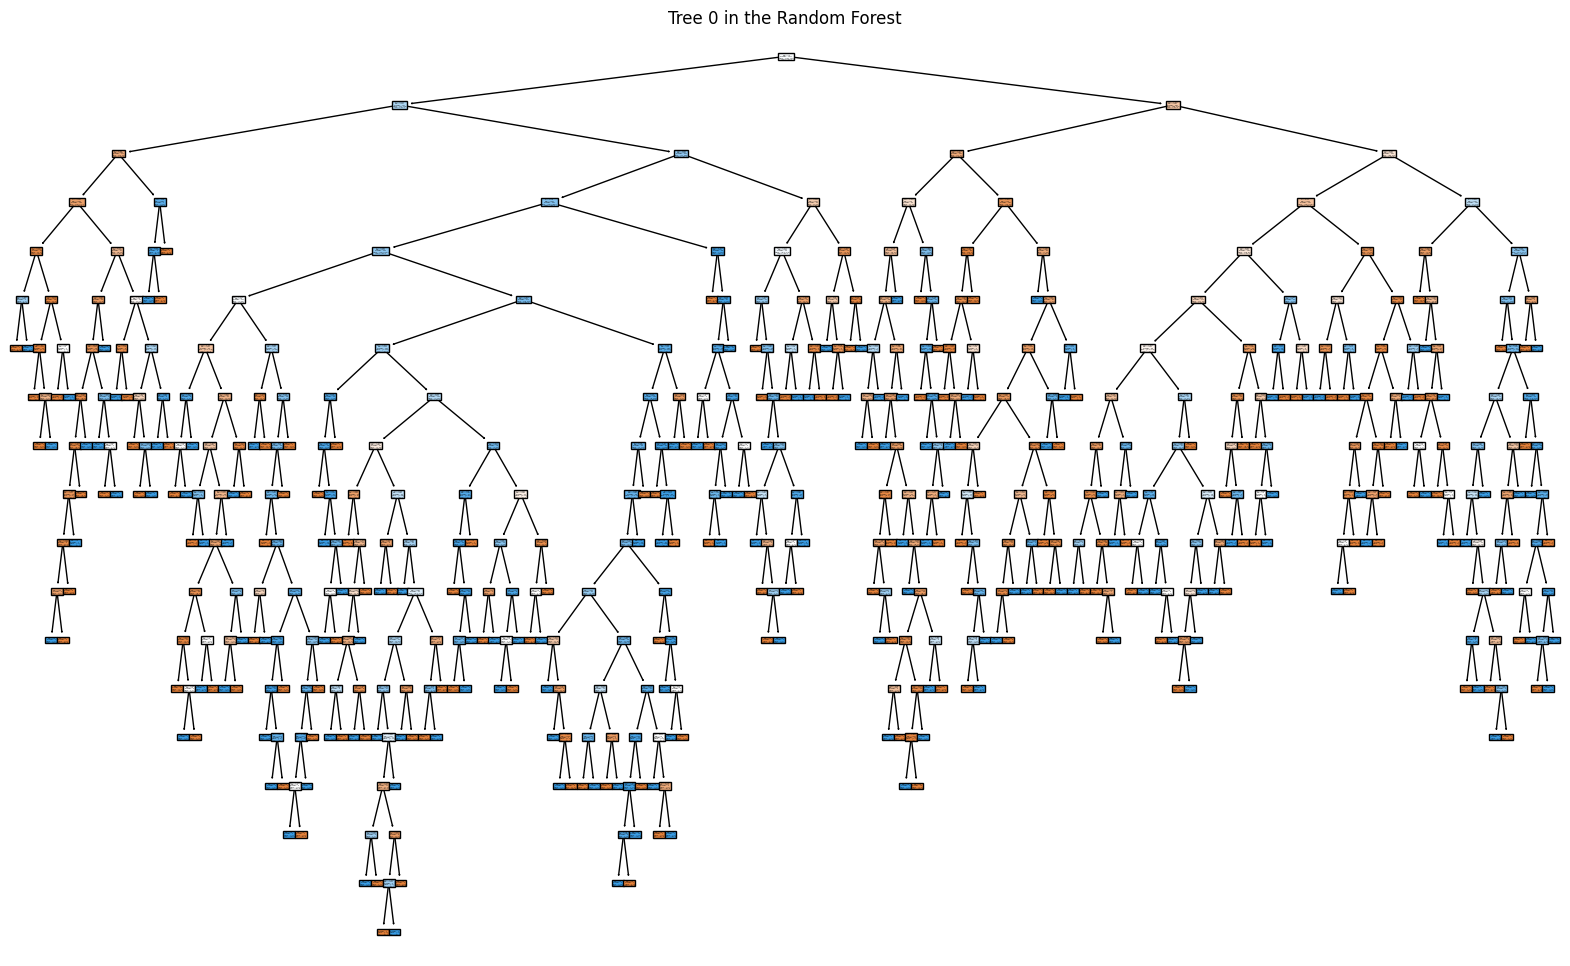

In [108]:
tree_index = 0
plt.figure(figsize=(20, 12))  # Adjust the size as needed
plot_tree(rf_model.estimators_[tree_index], filled=True, feature_names=X_train_scaled.columns.tolist(), class_names=['Class 0', 'Class 1'])  # Adjust class names based on your problem
plt.title('Tree {} in the Random Forest'.format(tree_index))
plt.show()

Random Forest Feature Contributions (%):
kurtosis_distance: 39.8898%
kurtosis_duration: 18.6462%
skewness_distance: 13.5538%
variance_duration: 7.1755%
skewness_duration: 6.8653%
mean_duration: 6.4208%
variance_distance: 4.3732%
mean_distance: 3.0755%


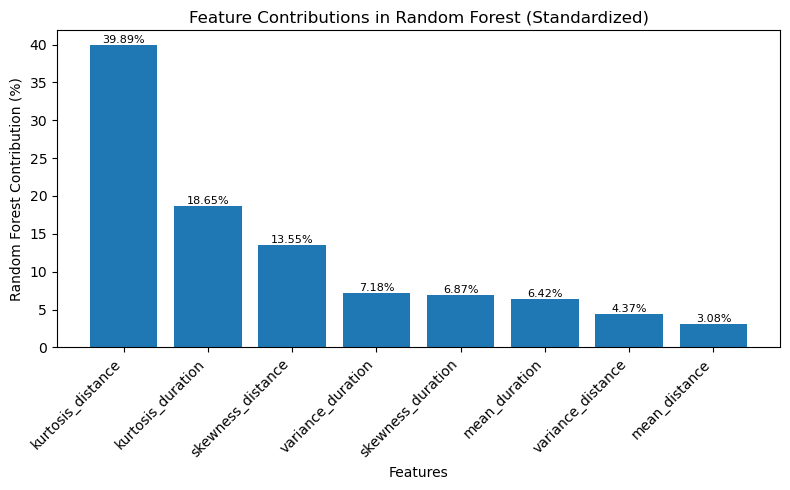

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 计算随机森林特征重要性，转成百分比
feature_importances = rf_model.feature_importances_
feature_names = X_train.columns

# 排序
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_features = feature_names[sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# 构建DataFrame方便绘图
feature_contributions = pd.DataFrame({
    "Feature": sorted_features,
    "RF Contribution (%)": sorted_importances * 100
})

print("Random Forest Feature Contributions (%):")
for i, row in feature_contributions.iterrows():
    print(f"{row['Feature']}: {row['RF Contribution (%)']:.4f}%")


# 绘图
plt.figure(figsize=(8, 5))
bars = plt.bar(feature_contributions["Feature"], feature_contributions["RF Contribution (%)"])
plt.ylabel("Random Forest Contribution (%)")
plt.xlabel("Features")
plt.title("Feature Contributions in Random Forest (Standardized)")
plt.xticks(rotation=45, ha='right')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.2f}%', ha='center', va='bottom', fontsize=8)


plt.tight_layout()
plt.show()



## Multi Layer Perceptron (MLP)

Accuracy: 0.9510481037198595
Classification Report:
               precision    recall  f1-score   support

          FV       0.94      0.96      0.95      8578
          TP       0.96      0.94      0.95      7928

    accuracy                           0.95     16506
   macro avg       0.95      0.95      0.95     16506
weighted avg       0.95      0.95      0.95     16506



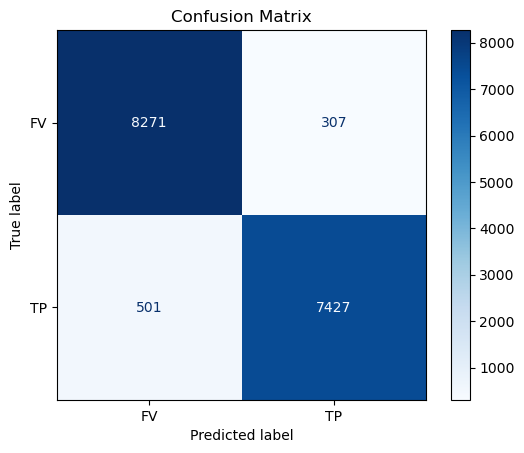

Training results updated: {'SVM': {'Accuracy': 0.8569611050527081, 'Precision': 0.8597044634338877, 'Recall': 0.8569611050527081, 'F1_Score': 0.8563651863880642}, 'DecisionTree': {'Accuracy': 0.9170604628619896, 'Precision': 0.9206249538857864, 'Recall': 0.9170604628619896, 'F1_Score': 0.9167121823665645}, 'RandomForest': {'Accuracy': 0.9153641100205986, 'Precision': 0.9230006550852881, 'Recall': 0.9153641100205986, 'F1_Score': 0.9147272941403064}, 'MLP': {'Accuracy': 0.9510481037198595, 'Precision': 0.9512528308315007, 'Recall': 0.9510481037198595, 'F1_Score': 0.9510186074568019}}


In [80]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Initialize the MLP classifier
mlp_model = MLPClassifier(
    hidden_layer_sizes=(50,),  # One hidden layer with 100 neurons
    activation='relu',         # Activation function
    solver='adam',             # Optimizer
    max_iter=200,              # Maximum number of iterations
    random_state=42            # Random state for reproducibility
)

# Train the MLP model
mlp_model.fit(X_train_scaled, y_train_encoded)  # Use encoded labels for training

# Predict on the test data
y_pred_encoded = mlp_model.predict(X_test_scaled)  # Predictions are encoded

# Convert predictions back to original labels
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Define class names
class_names = label_encoder.classes_  # ['FV', 'TP']

# Display the confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(
    y_test,  # True labels (original)
    y_pred,  # Predicted labels (original)
    display_labels=class_names,
    cmap=plt.cm.Blues
)

# Show the confusion matrix
plt.title("Confusion Matrix")
plt.show()

training_results["MLP"] = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": classification_report(y_test, y_pred, output_dict=True)["weighted avg"]["precision"],
    "Recall": classification_report(y_test, y_pred, output_dict=True)["weighted avg"]["recall"],
    "F1_Score": classification_report(y_test, y_pred, output_dict=True)["weighted avg"]["f1-score"]
}

print("Training results updated:", training_results)

## AdaBoost

Accuracy: 0.9429298436932024
Classification Report:
               precision    recall  f1-score   support

          FV       0.92      0.97      0.95      8578
          TP       0.97      0.91      0.94      7928

    accuracy                           0.94     16506
   macro avg       0.94      0.94      0.94     16506
weighted avg       0.94      0.94      0.94     16506



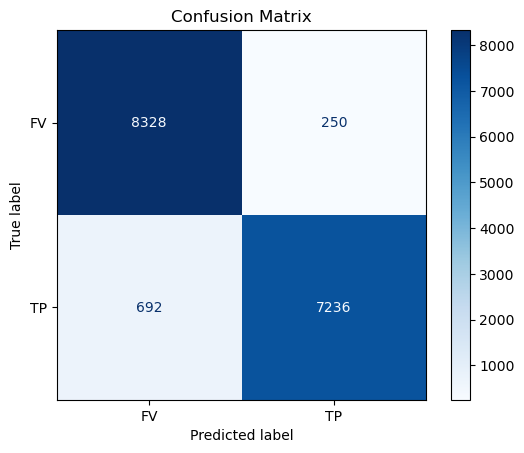

Training results updated: {'SVM': {'Accuracy': 0.8569611050527081, 'Precision': 0.8597044634338877, 'Recall': 0.8569611050527081, 'F1_Score': 0.8563651863880642}, 'DecisionTree': {'Accuracy': 0.9170604628619896, 'Precision': 0.9206249538857864, 'Recall': 0.9170604628619896, 'F1_Score': 0.9167121823665645}, 'RandomForest': {'Accuracy': 0.9153641100205986, 'Precision': 0.9230006550852881, 'Recall': 0.9153641100205986, 'F1_Score': 0.9147272941403064}, 'MLP': {'Accuracy': 0.9510481037198595, 'Precision': 0.9512528308315007, 'Recall': 0.9510481037198595, 'F1_Score': 0.9510186074568019}, 'AdaBoost': {'Accuracy': 0.9429298436932024, 'Precision': 0.944089945921424, 'Recall': 0.9429298436932024, 'F1_Score': 0.9428282947748869}, 'LogisticRegression': {'Accuracy': 0.8871925360474979, 'Precision': 0.8875332978305541, 'Recall': 0.8871925360474979, 'F1_Score': 0.8872300336574206}, 'kNN': {'Accuracy': 0.9382042893493275, 'Precision': 0.9384368131765737, 'Recall': 0.9382042893493275, 'F1_Score': 0.938

In [88]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Initialize the AdaBoost classifier
adaboost_model = AdaBoostClassifier(
    n_estimators=100,  # Number of weak learners
    random_state=42   # Random state for reproducibility
)

# Train the AdaBoost model
adaboost_model.fit(X_train_scaled, y_train_encoded)  # Use encoded labels for training

# Predict on the test data
y_pred_encoded = adaboost_model.predict(X_test_scaled)  # Predictions are encoded

# Convert predictions back to original labels
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Define class names
class_names = label_encoder.classes_  # ['FV', 'TP']

# Display the confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(
    y_test,  # True labels (original)
    y_pred,  # Predicted labels (original)
    display_labels=class_names,
    cmap=plt.cm.Blues
)

# Show the confusion matrix
plt.title("Confusion Matrix")
plt.show()

training_results["AdaBoost"] = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": classification_report(y_test, y_pred, output_dict=True)["weighted avg"]["precision"],
    "Recall": classification_report(y_test, y_pred, output_dict=True)["weighted avg"]["recall"],
    "F1_Score": classification_report(y_test, y_pred, output_dict=True)["weighted avg"]["f1-score"]
}

print("Training results updated:", training_results)

## Logistic Regression (LogReg)

Accuracy: 0.8871925360474979
Classification Report:
               precision    recall  f1-score   support

          FV       0.90      0.88      0.89      8578
          TP       0.87      0.90      0.88      7928

    accuracy                           0.89     16506
   macro avg       0.89      0.89      0.89     16506
weighted avg       0.89      0.89      0.89     16506



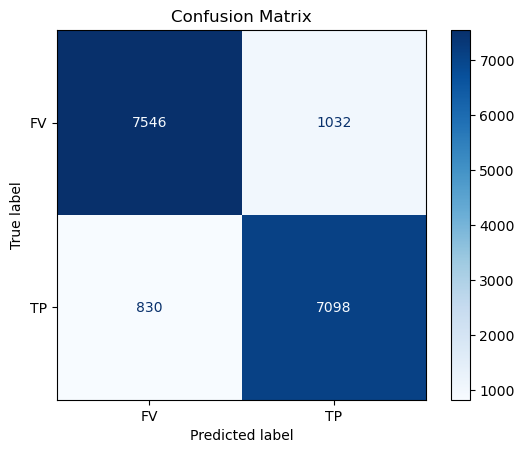

Training results updated: {'SVM': {'Accuracy': 0.8569611050527081, 'Precision': 0.8597044634338877, 'Recall': 0.8569611050527081, 'F1_Score': 0.8563651863880642}, 'DecisionTree': {'Accuracy': 0.9170604628619896, 'Precision': 0.9206249538857864, 'Recall': 0.9170604628619896, 'F1_Score': 0.9167121823665645}, 'RandomForest': {'Accuracy': 0.9153641100205986, 'Precision': 0.9230006550852881, 'Recall': 0.9153641100205986, 'F1_Score': 0.9147272941403064}, 'MLP': {'Accuracy': 0.9510481037198595, 'Precision': 0.9512528308315007, 'Recall': 0.9510481037198595, 'F1_Score': 0.9510186074568019}, 'AdaBoost': {'Accuracy': 0.9370531927783836, 'Precision': 0.9384422048028167, 'Recall': 0.9370531927783836, 'F1_Score': 0.9369246507679939}, 'LogisticRegression': {'Accuracy': 0.8871925360474979, 'Precision': 0.8875332978305541, 'Recall': 0.8871925360474979, 'F1_Score': 0.8872300336574206}}


In [82]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Initialize the Logistic Regression classifier
logreg_model = LogisticRegression(
    random_state=42,        # Random state for reproducibility
    max_iter=200,           # Maximum number of iterations
    solver='lbfgs',         # Optimization algorithm
    multi_class='auto'      # Automatically handle binary or multi-class classification
)

# Train the Logistic Regression model
logreg_model.fit(X_train_scaled, y_train_encoded)  # Use encoded labels for training

# Predict on the test data
y_pred_encoded = logreg_model.predict(X_test_scaled)  # Predictions are encoded

# Convert predictions back to original labels
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Define class names
class_names = label_encoder.classes_  # ['FV', 'TP']

# Display the confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(
    y_test,  # True labels (original)
    y_pred,  # Predicted labels (original)
    display_labels=class_names,
    cmap=plt.cm.Blues
)

# Show the confusion matrix
plt.title("Confusion Matrix")
plt.show()

training_results["LogisticRegression"] = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": classification_report(y_test, y_pred, output_dict=True)["weighted avg"]["precision"],
    "Recall": classification_report(y_test, y_pred, output_dict=True)["weighted avg"]["recall"],
    "F1_Score": classification_report(y_test, y_pred, output_dict=True)["weighted avg"]["f1-score"]
}

print("Training results updated:", training_results)

## k-Nearest-Neighbor (knn)

Accuracy: 0.9382042893493275
Classification Report:
               precision    recall  f1-score   support

          FV       0.93      0.95      0.94      8578
          TP       0.95      0.92      0.93      7928

    accuracy                           0.94     16506
   macro avg       0.94      0.94      0.94     16506
weighted avg       0.94      0.94      0.94     16506



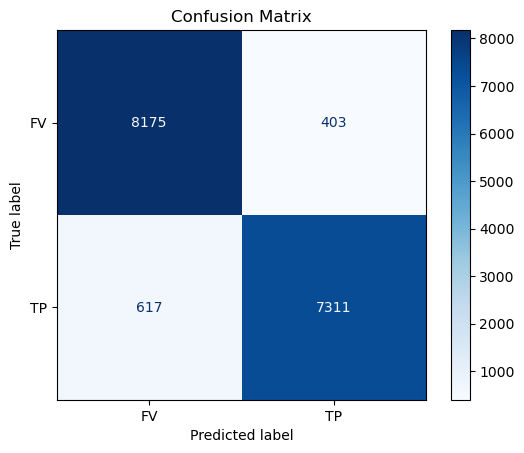

Training results updated: {'SVM': {'Accuracy': 0.8569611050527081, 'Precision': 0.8597044634338877, 'Recall': 0.8569611050527081, 'F1_Score': 0.8563651863880642}, 'DecisionTree': {'Accuracy': 0.9170604628619896, 'Precision': 0.9206249538857864, 'Recall': 0.9170604628619896, 'F1_Score': 0.9167121823665645}, 'RandomForest': {'Accuracy': 0.9153641100205986, 'Precision': 0.9230006550852881, 'Recall': 0.9153641100205986, 'F1_Score': 0.9147272941403064}, 'MLP': {'Accuracy': 0.9510481037198595, 'Precision': 0.9512528308315007, 'Recall': 0.9510481037198595, 'F1_Score': 0.9510186074568019}, 'AdaBoost': {'Accuracy': 0.9370531927783836, 'Precision': 0.9384422048028167, 'Recall': 0.9370531927783836, 'F1_Score': 0.9369246507679939}, 'LogisticRegression': {'Accuracy': 0.8871925360474979, 'Precision': 0.8875332978305541, 'Recall': 0.8871925360474979, 'F1_Score': 0.8872300336574206}, 'kNN': {'Accuracy': 0.9382042893493275, 'Precision': 0.9384368131765737, 'Recall': 0.9382042893493275, 'F1_Score': 0.93

In [83]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Initialize the KNN classifier
knn_model = KNeighborsClassifier(
    n_neighbors=5,  # Number of neighbors to use
    metric='minkowski',  # Distance metric (default is Minkowski)
    p=2  # Power parameter for Minkowski metric (p=2 corresponds to Euclidean distance)
)

# Train the KNN model
knn_model.fit(X_train_scaled, y_train_encoded)  # Use encoded labels for training

# Predict on the test data
y_pred_encoded = knn_model.predict(X_test_scaled)  # Predictions are encoded

# Convert predictions back to original labels
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Define class names
class_names = label_encoder.classes_  # ['FV', 'TP']

# Display the confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(
    y_test,  # True labels (original)
    y_pred,  # Predicted labels (original)
    display_labels=class_names,
    cmap=plt.cm.Blues
)

# Show the confusion matrix
plt.title("Confusion Matrix")
plt.show()

training_results["kNN"] = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": classification_report(y_test, y_pred, output_dict=True)["weighted avg"]["precision"],
    "Recall": classification_report(y_test, y_pred, output_dict=True)["weighted avg"]["recall"],
    "F1_Score": classification_report(y_test, y_pred, output_dict=True)["weighted avg"]["f1-score"]
}

print("Training results updated:", training_results)

## Naïve Bayes (NB)

Accuracy: 0.7783836180782746
Classification Report:
               precision    recall  f1-score   support

          FV       0.90      0.65      0.75      8578
          TP       0.71      0.92      0.80      7928

    accuracy                           0.78     16506
   macro avg       0.80      0.78      0.78     16506
weighted avg       0.81      0.78      0.77     16506



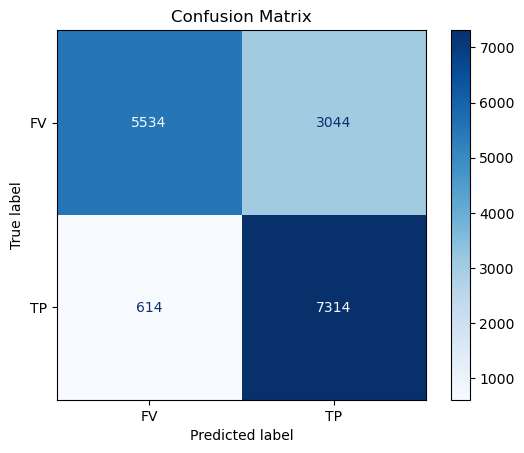

Training results updated: {'SVM': {'Accuracy': 0.8569611050527081, 'Precision': 0.8597044634338877, 'Recall': 0.8569611050527081, 'F1_Score': 0.8563651863880642}, 'DecisionTree': {'Accuracy': 0.9170604628619896, 'Precision': 0.9206249538857864, 'Recall': 0.9170604628619896, 'F1_Score': 0.9167121823665645}, 'RandomForest': {'Accuracy': 0.9153641100205986, 'Precision': 0.9230006550852881, 'Recall': 0.9153641100205986, 'F1_Score': 0.9147272941403064}, 'MLP': {'Accuracy': 0.9510481037198595, 'Precision': 0.9512528308315007, 'Recall': 0.9510481037198595, 'F1_Score': 0.9510186074568019}, 'AdaBoost': {'Accuracy': 0.9370531927783836, 'Precision': 0.9384422048028167, 'Recall': 0.9370531927783836, 'F1_Score': 0.9369246507679939}, 'LogisticRegression': {'Accuracy': 0.8871925360474979, 'Precision': 0.8875332978305541, 'Recall': 0.8871925360474979, 'F1_Score': 0.8872300336574206}, 'kNN': {'Accuracy': 0.9382042893493275, 'Precision': 0.9384368131765737, 'Recall': 0.9382042893493275, 'F1_Score': 0.93

In [86]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Initialize the Naive Bayes classifier
nb_model = GaussianNB()

# Train the Naive Bayes model
nb_model.fit(X_train_scaled, y_train_encoded)  # Use scaled features and encoded labels for training

# Predict on the test data
y_pred_encoded = nb_model.predict(X_test_scaled)  # Predictions are encoded

# Convert predictions back to original labels
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Define class names
class_names = label_encoder.classes_  # ['FV', 'TP']

# Display the confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(
    y_test,  # True labels (original)
    y_pred,  # Predicted labels (original)
    display_labels=class_names,
    cmap=plt.cm.Blues
)

# Show the confusion matrix
plt.title("Confusion Matrix")
plt.show()

# Update training results
training_results["NaiveBayes"] = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": classification_report(y_test, y_pred, output_dict=True)["weighted avg"]["precision"],
    "Recall": classification_report(y_test, y_pred, output_dict=True)["weighted avg"]["recall"],
    "F1_Score": classification_report(y_test, y_pred, output_dict=True)["weighted avg"]["f1-score"]
}

print("Training results updated:", training_results)

In [89]:
# Define the path to save the training results
training_results_path = "/home/oct/COCO_Search18-and-FV/dataset/training_results.json"

# Save the training results to a JSON file
with open(training_results_path, 'w') as file:
    json.dump(training_results, file, indent=4)

print(f"Training results saved to {training_results_path}")

Training results saved to /home/oct/COCO_Search18-and-FV/dataset/training_results.json


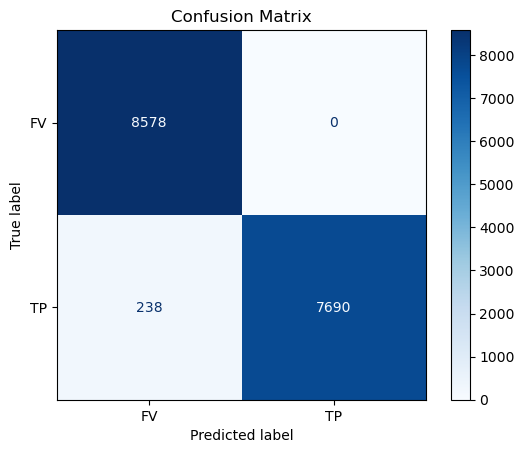

In [1]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

# 构造混淆矩阵
cm = np.array([[8578, 0],     # 实际为 FV
               [238, 7690]])  # 实际为 TP

# 类别标签
class_names = ['FV', 'TP']

# 绘制混淆矩阵，设置 values_format='d' 显示整数
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names)

disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()
